In [1]:
import sys, os
ROOT = os.path.abspath("..")   # go up one directory from notebooks/
if ROOT not in sys.path:
    sys.path.append(ROOT)

print(ROOT)  


c:\Users\tdiks\Documents\PINN_gravity_exp


In [2]:
from src2.networks import get_all_networks
from src2.config import CONFIG

from src2.sampling import (
    sample_domain_points,
    sample_top_surface,
    sample_interface,
    sample_far_field
)

from src2.losses import total_loss

from src2.pde_residuals import (
    residual_layer_coupled,
    residual_halfspace
)

from src2.boundary_conditions import (
    top_surface_bc,
    interface_layer_halfspace,
    halfspace_far_field_bc
)


# — Torch + Device

In [3]:
import torch
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


# Build-Models

In [4]:
model_layer, model_half = get_all_networks()

model_layer.to(DEVICE)
model_half.to(DEVICE)


PINN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): Tanh()
    (16): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Load Config & Geometry

In [5]:
geom = CONFIG["GEOMETRY"]

params_layer = CONFIG["LAYER"]
params_half  = CONFIG["HALFSPACE"]
dispersion = []   # <-- DEFINE DISPERSION HERE


# Define trainable phase velocity (c)

In [6]:
c = torch.nn.Parameter(
    torch.tensor(
        (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
        device=DEVICE
    )
)


# Optimizer

In [7]:
optimizer = optim.Adam(
    list(model_layer.parameters()) +
    list(model_half.parameters()) +
    [c],
    lr=1e-2
)


# Training Loop (Simple + Transparent)

In [8]:
# Training Loop (Dispersion)
k_values = torch.linspace(
    CONFIG["GEOMETRY"]["k_min"],
    CONFIG["GEOMETRY"]["k_max"],
    CONFIG["GEOMETRY"]["num_k"]
)
k_values

tensor([0.5000, 0.6071, 0.7143, 0.8214, 0.9286, 1.0357, 1.1429, 1.2500, 1.3571,
        1.4643, 1.5714, 1.6786, 1.7857, 1.8929, 2.0000])

In [9]:
# --------------------------------------------------
# Build models ONCE (outside k-loop)
# --------------------------------------------------
model_layer, model_half = get_all_networks()
model_layer.to(DEVICE)
model_half.to(DEVICE)

 # Define trainable phase velocity (c)
c = torch.nn.Parameter(
        torch.tensor(
            (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
            device=DEVICE
        )
    )
optimizer = optim.Adam(
    [
        {"params": model_layer.parameters(), "lr": 1e-4},
        {"params": model_half.parameters(), "lr": 1e-4},
        {"params": [c], "lr": 1e-4},
    ]
)

dispersion = []

# --------------------------------------------------
# k-loop (CONTINUATION)
# --------------------------------------------------
for k in k_values:

    print(f"\nTraining for k = {k.item():.3f}")

    for epoch in range(1, 30):

        z_layer, z_half = sample_domain_points(1000, geom)
        z_top = sample_top_surface(1000, geom)
        z_int = sample_interface(1000)
        z_far = sample_far_field(1000, geom)

        optimizer.zero_grad()

        loss, logs = total_loss(
            model_layer,
            model_half,
            z_layer,
            z_half,
            z_top,
            z_int,
            z_far,
            params_layer,
            params_half,
            k.item(),     
            c,
            w_pde=1.0,
            w_bc=0.05,
            w_int=1e-4,
            w_far=1e-5,
        )

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            c.clamp_(min=0.5)

        if epoch % 10 == 0:
          print(
        f"k={k.item():.2f} | "
        f"Epoch {epoch} | "
        f"Loss={loss.item():.3e} | "
        f"PDE={logs['pde']:.2e} | "
        f"BC={logs['bc_top']:.2e} | "
        f"INT={logs['interface']:.2e} | "
        f"FAR={logs['far']:.2e} | "
        
    )

    dispersion.append([k.item(), c.item()])





Training for k = 0.500
k=0.50 | Epoch 10 | Loss=1.636e-01 | PDE=4.27e-03 | BC=8.61e-05 | INT=2.94e-02 | FAR=3.35e-04 | 
k=0.50 | Epoch 20 | Loss=1.290e-01 | PDE=1.48e-02 | BC=1.61e-04 | INT=1.07e-01 | FAR=1.47e-05 | 

Training for k = 0.607
k=0.61 | Epoch 10 | Loss=4.829e-02 | PDE=1.58e-02 | BC=4.03e-04 | INT=7.47e-01 | FAR=7.22e-06 | 
k=0.61 | Epoch 20 | Loss=6.758e-03 | PDE=2.26e-03 | BC=2.43e-03 | INT=1.73e+00 | FAR=5.21e-08 | 

Training for k = 0.714
k=0.71 | Epoch 10 | Loss=2.216e-03 | PDE=1.69e-03 | BC=1.83e-03 | INT=2.58e+00 | FAR=3.82e-07 | 
k=0.71 | Epoch 20 | Loss=1.629e-03 | PDE=8.23e-04 | BC=2.49e-03 | INT=2.23e+00 | FAR=5.16e-07 | 

Training for k = 0.821
k=0.82 | Epoch 10 | Loss=2.587e-03 | PDE=1.61e-03 | BC=3.03e-03 | INT=2.33e+00 | FAR=1.20e-08 | 
k=0.82 | Epoch 20 | Loss=2.102e-03 | PDE=1.67e-03 | BC=3.12e-03 | INT=2.54e+00 | FAR=8.66e-08 | 

Training for k = 0.929
k=0.93 | Epoch 10 | Loss=2.812e-03 | PDE=1.99e-03 | BC=3.59e-03 | INT=2.45e+00 | FAR=5.85e-07 | 
k=0.93 

In [10]:
torch.save({
    "model_layer": model_layer.state_dict(),
    "model_half": model_half.state_dict(),
    "c": c.detach().cpu()
}, "dispersion_pinn.pth")

print("Model saved.")


Model saved.


Choose time & y-location

In [11]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

H = geom["H"]   # layer thickness
L = geom["L"]   # half-space depth


Create a point in each layer

In [12]:
# z-grid for plotting / post-processing

z_layer = torch.linspace(-H, 0.0, 200).reshape(-1, 1).to(DEVICE)
z_half  = torch.linspace(0.0, L, 200).reshape(-1, 1).to(DEVICE)


Feed to model

In [13]:
with torch.no_grad():

    scale = 1e-2
# Layer (complex amplitude)   
    
V_layer = model_layer(z_layer)
V_R = V_layer[:, 0:1]
V_I =  V_layer[:, 1:2]
# Half-space (real amplitude)
V_half =  model_half(z_half)



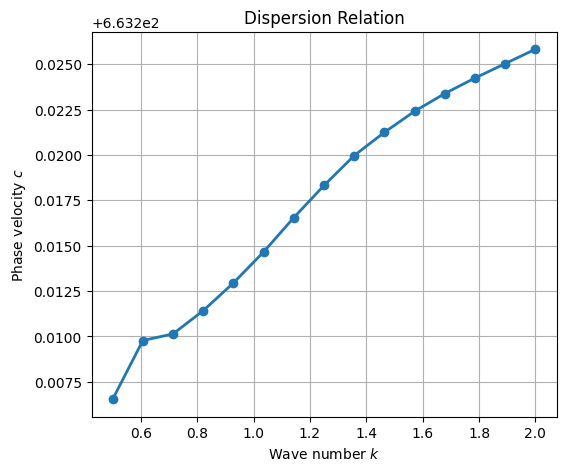

In [14]:
import matplotlib.pyplot as plt
import torch

# dispersion: shape (N, 2) → [k, c]
dispersion = torch.tensor(dispersion)
# dispersion: shape (N, 2) → [k, c]
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]


plt.figure(figsize=(6,5))
plt.plot(k_vals, c_vals, 'o-', linewidth=2, markersize=6)

plt.xlabel("Wave number $k$")
plt.ylabel("Phase velocity $c$")
plt.title("Dispersion Relation")
plt.grid(True)

plt.show()


Plot Disperion curves


Layer properties:
  μ₄₄ = 4.35e+09 Pa
  ρ = 9890 kg/m³
  c_ref = √(μ₄₄/ρ) = 663.2 m/s
  H = 1


C:\Users\tdiks\AppData\Local\Temp\ipykernel_15800\2828792633.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dispersion = torch.tensor(dispersion)


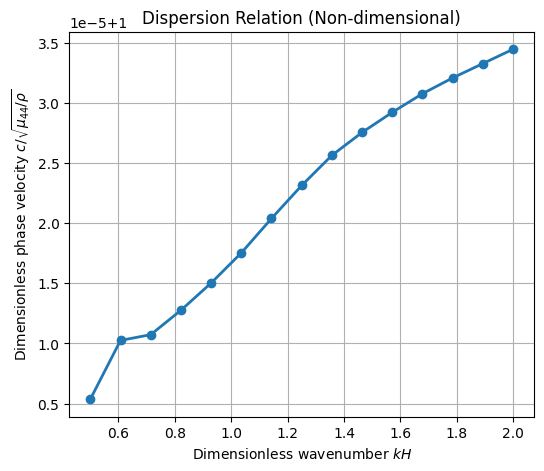


Dispersion data (non-dimensional):
   kH        c/c_ref
   0.500     1.000
   0.607     1.000
   0.714     1.000
   0.821     1.000
   0.929     1.000
   1.036     1.000
   1.143     1.000
   1.250     1.000
   1.357     1.000
   1.464     1.000
   1.571     1.000
   1.679     1.000
   1.786     1.000
   1.893     1.000
   2.000     1.000


In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Your dispersion data
dispersion = torch.tensor(dispersion)
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]

# Material properties for layer (from your config)
mu44_layer = 4.35e9  # Pa
rho_layer = 9890.0  # kg/m³
H = 1 # Layer thickness (non-dimensional)

# Calculate reference velocity: √(μ₆₆/ρ) for layer
c_ref_layer = np.sqrt(mu44_layer / rho_layer)# Reference shear speed

print(f"Layer properties:")
print(f"  μ₄₄ = {mu44_layer:.2e} Pa")
print(f"  ρ = {rho_layer:.0f} kg/m³")
print(f"  c_ref = √(μ₄₄/ρ) = {c_ref_layer:.1f} m/s")
print(f"  H = {H}")

# Non-dimensionalize
kH = k_vals * H                     # Dimensionless wavenumber
c_norm = c_vals / c_ref_layer       # Dimensionless phase velocity

# Plot
plt.figure(figsize=(6, 5))
plt.plot(kH, c_norm, 'o-', linewidth=2, markersize=6)

plt.xlabel("Dimensionless wavenumber $kH$")
plt.ylabel("Dimensionless phase velocity $c/\\sqrt{\\mu_{44}/\\rho}$")
plt.title("Dispersion Relation (Non-dimensional)")
plt.grid(True)

plt.show()

# Print the data
print("\nDispersion data (non-dimensional):")
print("   kH        c/c_ref")
for i in range(len(kH)):
    print(f"   {kH[i]:.3f}     {c_norm[i]:.3f}")

C:\Users\tdiks\AppData\Local\Temp\ipykernel_15800\2954668902.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dispersion = torch.tensor(dispersion)


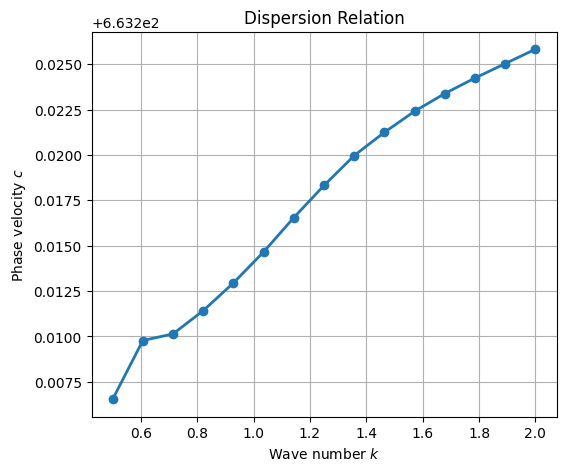

In [16]:
import matplotlib.pyplot as plt
import torch

# dispersion: shape (N, 2) → [k, c]
dispersion = torch.tensor(dispersion)
# dispersion: shape (N, 2) → [k, c]
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]


plt.figure(figsize=(6,5))
plt.plot(k_vals, c_vals, 'o-', linewidth=2, markersize=6)

plt.xlabel("Wave number $k$")
plt.ylabel("Phase velocity $c$")
plt.title("Dispersion Relation")
plt.grid(True)

plt.show()


In [17]:
k_vals

tensor([0.5000, 0.6071, 0.7143, 0.8214, 0.9286, 1.0357, 1.1429, 1.2500, 1.3571,
        1.4643, 1.5714, 1.6786, 1.7857, 1.8929, 2.0000])

In [18]:
c_vals

tensor([663.2065, 663.2098, 663.2101, 663.2114, 663.2130, 663.2147, 663.2166,
        663.2183, 663.2200, 663.2213, 663.2224, 663.2234, 663.2242, 663.2250,
        663.2258])

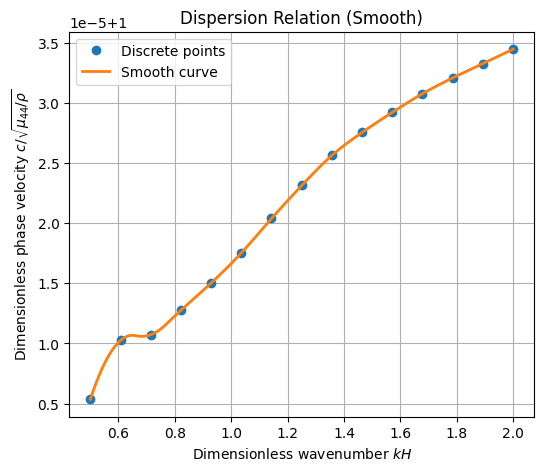

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# If not already done, convert tensors to numpy arrays
kH_np = kH.cpu().numpy() if hasattr(kH, 'cpu') else np.array(kH)
c_norm_np = c_norm.cpu().numpy() if hasattr(c_norm, 'cpu') else np.array(c_norm)

# Sort values for interpolation (required for spline)
sort_idx = np.argsort(kH_np)
kH_sorted = kH_np[sort_idx]
c_norm_sorted = c_norm_np[sort_idx]

# Create smooth curve using cubic spline
kH_smooth = np.linspace(kH_sorted.min(), kH_sorted.max(), 300)
spline = make_interp_spline(kH_sorted, c_norm_sorted, k=2)
c_norm_smooth = spline(kH_smooth)

# Plot both discrete points and smooth curve
plt.figure(figsize=(6, 5))
plt.plot(kH_sorted, c_norm_sorted, 'o', label='Discrete points')
plt.plot(kH_smooth, c_norm_smooth, '-', label='Smooth curve', linewidth=2)
plt.xlabel("Dimensionless wavenumber $kH$")
plt.ylabel("Dimensionless phase velocity $c/\\sqrt{\\mu_{44}/\\rho}$")
plt.title("Dispersion Relation (Smooth)")
plt.grid(True)
plt.legend()
plt.show()

In [20]:
# Save PINN dispersion data
np.savetxt(
    "PINN_dispersion.csv",
    np.column_stack((kH_sorted, c_norm_sorted)),
    delimiter=",",
    header="kH,c_pinn",
    comments=""
)


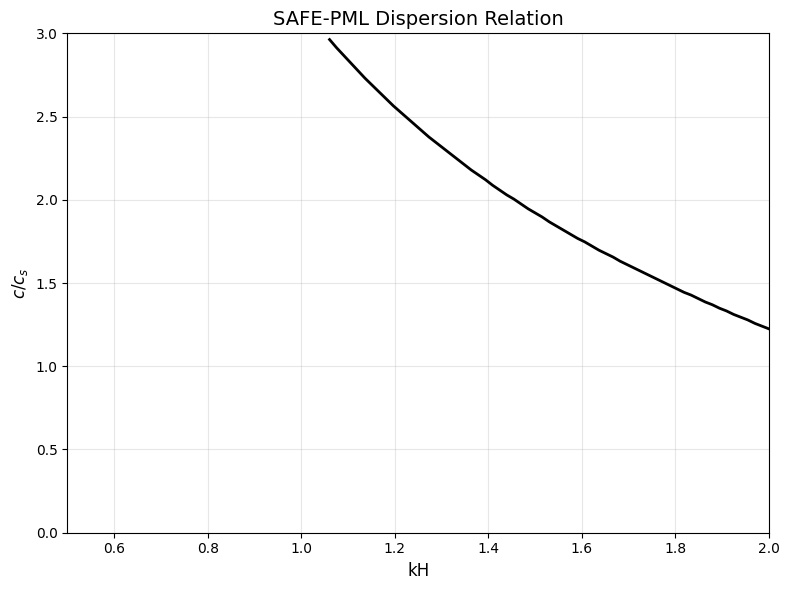

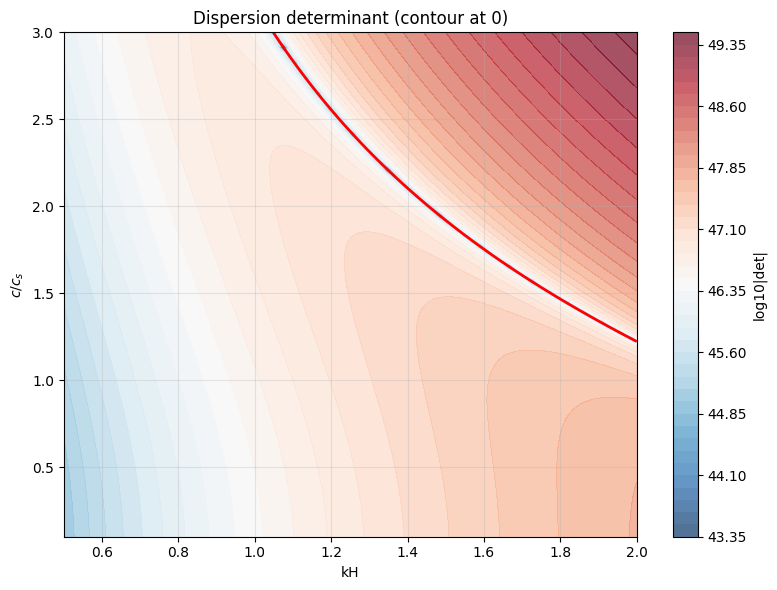

FEM data saved to 'FEM_dispersion.csv' with 63 points


In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
mu44l = 4.35e9
mu66l = 5.0e9
mu44h = 5.3e9
mu66h = 6.47e9
rho1 = 9890
rho2 = 3400
g = 9.81

H = 0.1
beta1 = 0.5
beta2 = 0.5
P1 = 1e9
P2 = 1e9
phi = np.pi / 6
mu_eH02 = 0.3 * mu44l

l = 29 * H
v = 7 + 7j  # Fixed to match MATLAB
c_s = np.sqrt(mu44l / rho1)

# --- Shape functions ---
def chi(xi):
    return np.array([
        xi * (xi - 1) / 2,
        1 - xi**2,
        xi * (xi + 1) / 2
    ])

def dchi(xi):
    return np.array([
        (2 * xi - 1) / 2,
        -2 * xi,
        (2 * xi + 1) / 2
    ])

# --- Gauss integration ---
gp = np.array([-np.sqrt(3/5), 0.0, np.sqrt(3/5)])
gw = np.array([5/9, 8/9, 5/9])

def assemble_KM(kH, cbar):
    k = kH / H
    omega = (kH / H) * cbar * c_s  # w = k * c
    
    # Initialize global matrices
    K_global = np.zeros((5, 5), dtype=complex)
    M_global = np.zeros((5, 5), dtype=complex)
    
    # === Element 1 ===
    J1 = H / 2
    Ke1 = np.zeros((3, 3), dtype=complex)
    Me1 = np.zeros((3, 3), dtype=complex)
    
    for ig in range(3):
        xi = gp[ig]
        wg = gw[ig]
        
        N = chi(xi)
        dN = dchi(xi)
        wfac1 = 1 + np.sin(beta1 * H * (xi + 1) / 2)
        
        for i in range(3):
            for j in range(3):
                term1 = -k**2 * mu66l * N[i] * N[j]
                term2 = (1 / J1**2) * mu44l * dN[i] * dN[j]
                term3 = (P1 / 2) * k**2 * N[i] * N[j]
                term4 = mu_eH02 * (
                    -k**2 * (np.cos(phi))**2 * N[i] * N[j]
                    + 1j * k * np.sin(2 * phi) / J1 * N[i] * dN[j]
                    + (np.sin(phi))**2 / J1**2 * dN[i] * dN[j]
                )
                
                Ke1[i, j] += (wfac1 * (term1 + term2 + term3+ term4)) * J1 * wg
                Me1[i, j] += rho1 * wfac1 * N[i] * N[j] * J1 * wg
    
    # === Element 2 (PML) ===
    J2 = l / 2
    Ke2 = np.zeros((3, 3), dtype=complex)
    Me2 = np.zeros((3, 3), dtype=complex)
    
    for ig in range(3):
        xi = gp[ig]
        wg = gw[ig]
        
        N = chi(xi)
        dN = dchi(xi)
        wfac2 = 1 - np.sin(beta2 * H * (xi + 1) / 2)
        x_val = H * (xi + 1) / 2  # z-coordinate
        
        for i in range(3):
            for j in range(3):
                # Basic terms
                term1 = -k**2 * mu66h * N[i] * N[j]
                term2 = (1 / (J2**2 * v**2)) * mu44h * dN[i] * dN[j]
                term3 = (P2 / 2) * k**2 * N[i] * N[j]
                
                # Gravity terms (terms 4-7 from MATLAB)
                term4a = -(rho2 * g / 2) * x_val * N[i] * N[j] / (J2**2 * v**2)

                term4b = (k**2 * rho2 * g / 2) * x_val * N[i] * N[j]

                term5 = -(g / 2) * x_val * rho2 * (N[i] * dN[j]) / (J2 * v)

                term6 = -(g / 2) * x_val * rho2 * (dN[i] * N[j]) / (J2 * v)

                term7 = -(g / 2) * rho2 * (
                        (beta2**2 * H * (xi + 1)) / 2 + 2 * beta2
                    ) * N[i] * N[j]
              
                # Combine all terms
                Ke2[i, j] += (wfac2 * (term1 + term2 + term3 + term4a + term4b + term5 + term6 + term7)) * v * J2 * wg
                Me2[i, j] += rho2 * wfac2 * N[i] * N[j] * v * J2 * wg
    
    # === Global Assembly ===
    # Element 1: nodes 1,2,3
    K_global[0:3, 0:3] += Ke1
    M_global[0:3, 0:3] += Me1
    
    # Element 2: nodes 3,4,5
    K_global[2:5, 2:5] += Ke2
    M_global[2:5, 2:5] += Me2
    
    # === Apply boundary condition (remove DOF 5) ===
    K_reduced = np.delete(K_global, 4, axis=0)
    K_reduced = np.delete(K_reduced, 4, axis=1)
    M_reduced = np.delete(M_global, 4, axis=0)
    M_reduced = np.delete(M_reduced, 4, axis=1)
    
    return K_reduced, M_reduced, omega

def det_A(kH, cbar):
    K, M, omega = assemble_KM(kH, cbar)
    A = K - omega**2 * M
    return np.real(np.linalg.det(A))

# === Root finding for dispersion curve ===
kH_range = np.linspace(0.5, 2.0, 100)
c_range = np.linspace(0.1, 3.0, 700)

kH_points = []
c_points = []

for kH in kH_range:
    det_vals = []
    for c in c_range:
        det_vals.append(det_A(kH, c))
    
    det_vals = np.array(det_vals)
    
    for i in range(len(c_range) - 1):

    # sign change = det(A)=0 in between
     if np.sign(det_vals[i]) != np.sign(det_vals[i + 1]):

        c_root = np.interp(
            0.0,
            [det_vals[i], det_vals[i + 1]],
            [c_range[i], c_range[i + 1]]
        )

        kH_points.append(kH)
        c_points.append(c_root)
        break   # first (physical) mode only


# === Plotting ===
plt.figure(figsize=(8, 6))
plt.plot(kH_points, c_points, 'k-', linewidth=2)
plt.xlabel('kH', fontsize=12)
plt.ylabel(r'$c/c_s$', fontsize=12)
plt.title('SAFE-PML Dispersion Relation', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim([0.5, 2.0])
plt.ylim([0, 3.0])
plt.tight_layout()
plt.show()

# Optional: Also plot contour for verification
if True:
    kH_vals = np.linspace(0.5, 2.0, 100)
    c_vals = np.linspace(0.1, 3.0, 100)
    KHH, CC = np.meshgrid(kH_vals, c_vals)
    
    Z = np.zeros_like(KHH)
    for i in range(KHH.shape[0]):
        for j in range(KHH.shape[1]):
            Z[i, j] = det_A(KHH[i, j], CC[i, j])
    
    plt.figure(figsize=(8, 6))
    plt.contour(KHH, CC, Z, levels=[0], colors='r', linewidths=2)
    plt.contourf(KHH, CC, np.log10(np.abs(Z) + 1), levels=50, cmap='RdBu_r', alpha=0.7)
    plt.colorbar(label='log10|det|')
    plt.xlabel('kH')
    plt.ylabel(r'$c/c_s$')
    plt.title('Dispersion determinant (contour at 0)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    # === ADD THESE 3 LINES AT THE END OF YOUR FILE ===

# Save FEM dispersion data (after the plotting code)
np.savetxt(
    "FEM_dispersion.csv",
    np.column_stack((kH_points, c_points)),
    delimiter=",",
    header="kH,c_fem",
    comments=""
)

print(f"FEM data saved to 'FEM_dispersion.csv' with {len(kH_points)} points")

In [22]:
# Save PINN dispersion data
np.savetxt(
    "FEM_dispersion.csv",
    np.column_stack((kH_points, c_points)),
    delimiter=",",
    header="kH,c_fem",
    comments=""
)


In [23]:
np.savetxt(
    "PINN_dispersion.csv",
    np.column_stack((kH_np, c_norm_np)),
    delimiter=",",
    header="kH,c_pinn",
    comments=""
)


In [24]:
import numpy as np

fem = np.loadtxt("FEM_dispersion.csv", delimiter=",", skiprows=1)

print("FEM array shape:", fem.shape)
print(fem)


FEM array shape: (63, 2)
[[1.06060606 2.96266094]
 [1.07575758 2.91287554]
 [1.09090909 2.86723891]
 [1.10606061 2.82160229]
 [1.12121212 2.77596567]
 [1.13636364 2.73032904]
 [1.15151515 2.6888412 ]
 [1.16666667 2.64735336]
 [1.18181818 2.60586552]
 [1.1969697  2.56437768]
 [1.21212121 2.52703863]
 [1.22727273 2.48969957]
 [1.24242424 2.45236052]
 [1.25757576 2.41502146]
 [1.27272727 2.3776824 ]
 [1.28787879 2.34449213]
 [1.3030303  2.31130186]
 [1.31818182 2.27811159]
 [1.33333333 2.24492132]
 [1.34848485 2.21173104]
 [1.36363636 2.17854077]
 [1.37878788 2.14949928]
 [1.39393939 2.1204578 ]
 [1.40909091 2.08726753]
 [1.42424242 2.05822604]
 [1.43939394 2.02918455]
 [1.45454545 2.00429185]
 [1.46969697 1.97525036]
 [1.48484848 1.94620887]
 [1.5        1.92131617]
 [1.51515152 1.89642346]
 [1.53030303 1.86738197]
 [1.54545455 1.84248927]
 [1.56060606 1.81759657]
 [1.57575758 1.79270386]
 [1.59090909 1.76781116]
 [1.60606061 1.74706724]
 [1.62121212 1.72217454]
 [1.63636364 1.69728183]


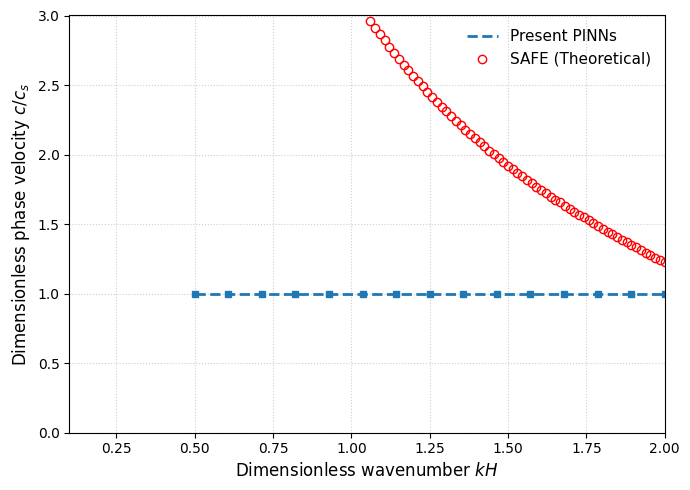

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# ==============================
# Load data
# ==============================
pinn = np.loadtxt("PINN_dispersion.csv", delimiter=",", skiprows=1)
fem  = np.loadtxt("FEM_dispersion.csv",  delimiter=",", skiprows=1)

kH_pinn = pinn[:, 0]
c_pinn  = pinn[:, 1]

kH_fem = fem[:, 0]
c_fem  = fem[:, 1]

# ==============================
# Smooth PINNs curve
# ==============================
sort_idx = np.argsort(kH_pinn)
kH_pinn_sorted = kH_pinn[sort_idx]
c_pinn_sorted  = c_pinn[sort_idx]

kH_smooth = np.linspace(kH_pinn_sorted.min(),
                        kH_pinn_sorted.max(), 300)

spline = make_interp_spline(kH_pinn_sorted, c_pinn_sorted, k=2)
c_pinn_smooth = spline(kH_smooth)

# ==============================
# Plot comparison
# ==============================
plt.figure(figsize=(7, 5))

# PINNs (dashed + squares)
plt.plot(
    kH_smooth,
    c_pinn_smooth,
    '--',
    color='tab:blue',
    linewidth=2,
    label='Present PINNs'
)
plt.plot(
    kH_pinn,
    c_pinn,
    's',
    color='tab:blue',
    markersize=5
)

# SAFE / FEM (circles)
plt.plot(
    kH_fem,
    c_fem,
    'o',
    color='red',
    markersize=6,
    markerfacecolor='none',
    label='SAFE (Theoretical)'
)

# ==============================
# Styling (match paper figure)
# ==============================
plt.xlabel(r'Dimensionless wavenumber $kH$', fontsize=12)
plt.ylabel(r'Dimensionless phase velocity $c/c_s$', fontsize=12)

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=11, frameon=False)

plt.xlim([0.1, 2.0])
plt.ylim([0.0, 3.0])

plt.tight_layout()
plt.show()
